In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.preprocessing import LabelEncoder, OneHotEncoder, StandardScaler, RobustScaler
from sklearn.model_selection import GridSearchCV, cross_val_score, KFold, RepeatedStratifiedKFold
from sklearn.model_selection import RepeatedKFold, train_test_split, RandomizedSearchCV
from sklearn.neighbors import  KNeighborsClassifier as knn
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier, VotingClassifier
import xgboost
from xgboost import XGBClassifier
from sklearn.metrics import auc, accuracy_score, confusion_matrix

In [2]:
train = pd.read_csv('/kaggle/input/titanic/train.csv')
test = pd.read_csv('/kaggle/input/titanic/test.csv')

In [3]:
df = pd.concat((train, test)).reset_index(drop=True)

In [4]:
df

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0.0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1.0,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1.0,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1.0,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0.0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S
...,...,...,...,...,...,...,...,...,...,...,...,...
1304,1305,NaN,3,"Spector, Mr. Woolf",male,NaN,0,0,A.5. 3236,8.0500,NaN,S
1305,1306,NaN,1,"Oliva y Ocana, Dona. Fermina",female,39.0,0,0,PC 17758,108.9000,C105,C
1306,1307,NaN,3,"Saether, Mr. Simon Sivertsen",male,38.5,0,0,SOTON/O.Q. 3101262,7.2500,NaN,S
1307,1308,NaN,3,"Ware, Mr. Frederick",male,NaN,0,0,359309,8.0500,NaN,S


In [5]:
df.head(10)

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0.0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1.0,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1.0,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1.0,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0.0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S
5,6,0.0,3,"Moran, Mr. James",male,NaN,0,0,330877,8.4583,NaN,Q
6,7,0.0,1,"McCarthy, Mr. Timothy J",male,54.0,0,0,17463,51.8625,E46,S
7,8,0.0,3,"Palsson, Master. Gosta Leonard",male,2.0,3,1,349909,21.0750,NaN,S
8,9,1.0,3,"Johnson, Mrs. Oscar W (Elisabeth Vilhelmina Berg)",female,27.0,0,2,347742,11.1333,NaN,S
9,10,1.0,2,"Nasser, Mrs. Nicholas (Adele Achem)",female,14.0,1,0,237736,30.0708,NaN,C


In [6]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1309 entries, 0 to 1308
Data columns (total 12 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   PassengerId  1309 non-null   int64  
 1   Survived     891 non-null    float64
 2   Pclass       1309 non-null   int64  
 3   Name         1309 non-null   object 
 4   Sex          1309 non-null   object 
 5   Age          1046 non-null   float64
 6   SibSp        1309 non-null   int64  
 7   Parch        1309 non-null   int64  
 8   Ticket       1309 non-null   object 
 9   Fare         1308 non-null   float64
 10  Cabin        295 non-null    object 
 11  Embarked     1307 non-null   object 
dtypes: float64(3), int64(4), object(5)
memory usage: 122.8+ KB


In [7]:
df.isnull().sum()

PassengerId       0
Survived        418
Pclass            0
Name              0
Sex               0
Age             263
SibSp             0
Parch             0
Ticket            0
Fare              1
Cabin          1014
Embarked          2
dtype: int64

In [8]:
# missing values
df['Age'] = df.Age.fillna(df.Age.median())
df['Fare'] = df.Fare.fillna(df.Fare.median())
df.dropna(subset=['Embarked'], inplace=True)
cabins = (df['Cabin'])
df.drop(['Cabin'], axis=1, inplace=True)

In [9]:
# derivative features
df['CabinCnt'] = cabins.apply(lambda x: 0 if pd.isna(x) else len(x.split(' ')))
df['CabinClass'] = cabins.apply(lambda x: str(x)[0])
df['IsNumericTicket'] = df.Ticket.apply(lambda x: 1 if x.isnumeric() else 0)
df['TicketType'] = df.Ticket.apply(lambda x: ''.join(x.split(' ')[:-1]).replace('.','').replace('/','').lower() if len(x.split(' ')[:-1]) > 0 else 0)
df['Title'] = df.Name.apply(lambda x: x.split(',')[1].split('.')[0].strip())
df['Family'] = df.SibSp + df.Parch

In [10]:
# feature transform
numeric_vars = ['Age', 'SibSp', 'Parch', 'Fare', 'CabinCnt', 'Family']
ordinal_vars = ['Pclass']
nominal_vars = ['Name', 'Sex', 'Ticket', 'Embarked', 'CabinClass', 'IsNumericTicket', 'TicketType', 'Title']
df[nominal_vars] = df[nominal_vars].astype('str')

for feature in numeric_vars:
    df[feature] = np.log1p(df[feature])

scaler = StandardScaler()
numeric_vars = df.columns[(df.dtypes != 'object') & (df.columns != 'PassengerId') & (df.columns != 'Survived') & (df.columns != 'IsTrain')]
df[numeric_vars] = scaler.fit_transform(df[numeric_vars])

In [11]:
# split data
df.drop(['PassengerId', 'Name', 'Ticket'], axis=1, inplace=True)
data_dummies = pd.get_dummies(df)
X_train = data_dummies[data_dummies.Survived.notnull()].drop(['Survived'], axis=1)
y_train = data_dummies[data_dummies.Survived.notnull()].Survived
X_test = data_dummies[data_dummies.Survived.isnull()].drop(['Survived'], axis=1)

In [12]:
X_train.shape, y_train.shape, X_test.shape

((889, 76), (889,), (418, 76))

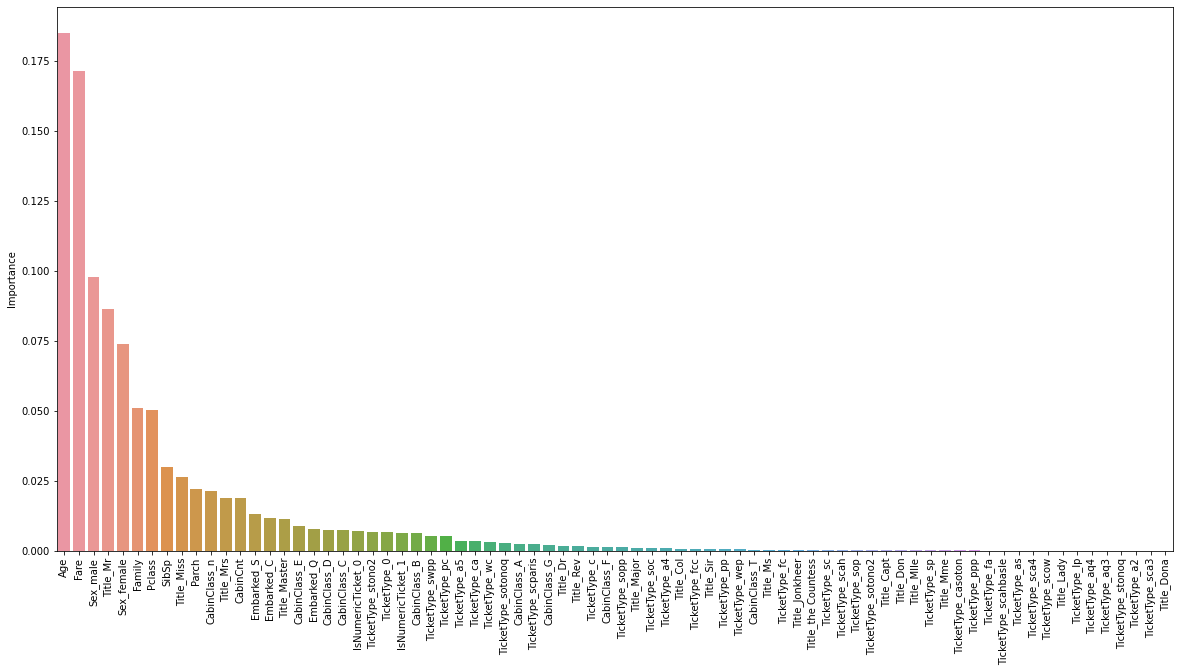

In [13]:
selector = RandomForestClassifier().fit(X_train, y_train)

imps = pd.DataFrame(selector.feature_importances_, X_train.columns, columns=['Importance'])
imps = pd.DataFrame(imps.Importance.sort_values(ascending=False))

plt.subplots(figsize=(20, 10))
g = sns.barplot(x=imps.index, y=imps.Importance)
g.set_xticklabels(g.get_xticklabels(),rotation = 90)
plt.show()

In [14]:
def xgb_gridsearch(params_grid_xgb, features, values, X, y, last=False):
    x_train, x_test = train_test_split(X, test_size=.2, random_state=42)
    y_train_tmp, y_test_tmp = train_test_split(y, test_size=.2, random_state=42)

    cv = RepeatedStratifiedKFold(n_splits = 10, n_repeats = 3, random_state = 42)

    model_xgb = XGBClassifier(use_label_encoder = False, 
                              objective = 'binary:logistic')
    
    for i in range(len(features)):
        params_grid_xgb[features[i]] = values[i]
    search_xgb = GridSearchCV(model_xgb, params_grid_xgb, verbose = 0,
                              scoring = 'neg_log_loss', cv = cv).fit(x_train, y_train_tmp, early_stopping_rounds = 15, 
                                  eval_set = [[x_test, y_test_tmp]], 
                                  eval_metric = 'logloss', verbose = False)
    for i in range(len(features)):
        print(f"{features[i]}: {search_xgb.best_params_[features[i]]}")
    if not last:
        for k, v in search_xgb.best_params_.items():
            search_xgb.best_params_[k] = [v]
    return search_xgb, search_xgb.best_params_

In [15]:
allow_tuning = False

In [16]:
from sklearn.neighbors import  KNeighborsClassifier as knn
if allow_tuning:
    params_knn = {
        'n_neighbors' : range(1, 10),
        'weights' : ['uniform', 'distance'],
        'algorithm' : ['auto', 'ball_tree','kd_tree'],
        'p' : [1,2]
    }
    model_knn = knn()
    search_knn = GridSearchCV(model_knn, params_knn, cv=5, scoring='accuracy', n_jobs=-1, verbose=1).fit(X_train, y_train)
    print(search_knn.best_params_)

In [17]:
if allow_tuning:
    params_logistic = {
        'max_iter': [2000],
        'penalty': ['l1', 'l2'],
        'C': np.logspace(-4, 4, 20),
        'solver': ['liblinear']
    }
    model_logistic = LogisticRegression()
    search_logistic = GridSearchCV(model_logistic, params_logistic, cv=5, scoring='accuracy', n_jobs=-1, verbose=1).fit(X_train, y_train)
    print(search_logistic.best_params_)

In [18]:
if allow_tuning:
    params_svc = [{'kernel': ['rbf'], 'gamma': [.01, .1, .5, 1, 2, 5, 10], 'C': [.1, 1, 10, 100, 1000], 'probability': [True]},
                  {'kernel': ['poly'], 'degree' : [2, 3, 4, 5], 'C': [.01, .1, 1, 10, 100, 1000], 'probability': [True]}]
    model_svc = SVC()
    search_svc = GridSearchCV(model_svc, params_svc, cv=5, scoring='accuracy', n_jobs=-1, verbose=1).fit(X_train, y_train)
    print(search_svc.best_params_)

In [19]:
if allow_tuning:
    params_svc = {'kernel': ['rbf'], 'gamma': [i/10000 for i in range(90, 110)], 'C': range(50, 80, 10), 'probability': [True]}
    model_svc = SVC()
    search_svc = GridSearchCV(model_svc, params_svc, cv=5, scoring='accuracy', n_jobs=-1, verbose=1).fit(X_train, y_train)
    print(search_svc.best_params_)

In [20]:
if allow_tuning:
    params_rf = {
        'n_estimators': [95, 100, 105],
        'criterion':['entropy'],
        'bootstrap': [True, False],
        'max_depth': [40, 45, 50],
        'max_features': [4, 5, 6],
        'min_samples_leaf': [1, 2, 3],
        'min_samples_split': [9, 10, 11],
        'random_state': [734]}
    model_rf = RandomForestClassifier()
    search_rf = GridSearchCV(model_rf, params_rf, cv=5, scoring='accuracy', n_jobs=-1, verbose=1).fit(X_train, y_train)
    search_rf.best_params_['random_state']=242
    search_rf.best_estimator_.random_state=242
    print(search_rf.best_params_)

In [21]:
if allow_tuning:
    # Initial params.
    params_xgb = {'n_estimators': [1000],
                  'learning_rate': [0.1],
                  'max_depth': [5],
                  'min_child_weight': [1],
                  'gamma': [0],
                  'subsample': [0.8],
                  'colsample_bytree': [0.8],
                  'n_jobs': [-1],
                  'objective': ['binary:logistic'],
                  'use_label_encoder': [False],
                  'eval_metric': ['logloss'],
                  'scale_pos_weight': [1]}
    
    # learning rate tuning.
    search_xgb, params_xgb = xgb_gridsearch(params_xgb, 
                                            ['learning_rate'], 
                                            [[0.01, 0.02, 0.03, 0.04, 0.05, 0.06, 0.07, 0.08, 0.09, 0.1, 0.15, 0.2]],
                                            X_train, y_train)
    # max_depth, min_child_weight tuning.
    search_xgb, params_xgb = xgb_gridsearch(params_xgb,
                                            ['max_depth', 'min_child_weight'],
                                            [range(3, 10), range(1, 6)],
                                            X_train, y_train)
    
    # gamma tuning.
    search_xgb, params_xgb = xgb_gridsearch(params_xgb,
                                            ['gamma'],
                                            [[0, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1, 2]],
                                            X_train, y_train)
    search_xgb, params_xgb = xgb_gridsearch(params_xgb,
                                            ['subsample', 'colsample_bytree'],
                                            [[i/100.0 for i in range(75,90,5)], [i/100.0 for i in range(75,90,5)]],
                                            X_train, y_train)
    
    # reg_alpha tuning.
    search_xgb, params_xgb = xgb_gridsearch(params_xgb,
                                            ['reg_alpha'], 
                                            [[1e-5, 1e-2, 0.1, 1, 100]], 
                                            X_train, y_train)
    
    # learning rate re tuning.
    params_xgb['n_estimators'] = [5000]
    search_xgb, params_xgb = xgb_gridsearch(params_xgb,
                                            ['learning_rate'],
                                            [[0.001, 0.005, 0.01, 0.02, 0.03, 0.04, 0.05, 0.06, 0.07, 0.08, 0.09, 0.1, 0.15, 0.2]],
                                            X_train, y_train, last=True)

    x_train, x_test = train_test_split(X_train, test_size=.2, random_state=42)
    y_train_tmp, y_test_tmp = train_test_split(y_train, test_size=.2, random_state=42)
    model_xgb = XGBClassifier(**params_xgb)
    
    # n_estimators tuning.
    model_xgb = model_xgb.fit(x_train, y_train_tmp, eval_set=[(x_test, y_test_tmp)], eval_metric=['logloss'], early_stopping_rounds=15, verbose=0)
    search_xgb.best_estimator_.n_estimators = model_xgb.best_iteration

In [22]:
if allow_tuning:
    model_knn = search_knn.best_estimator_
    model_logistic = search_logistic.best_estimator_
    model_svc = search_svc.best_estimator_
    model_rf = search_rf.best_estimator_
    model_xgb = search_xgb.best_estimator_
else:
    model_knn = knn(algorithm='auto', 
                    n_neighbors=9,
                    p=1, 
                    weights='uniform')
    
    model_logistic = LogisticRegression(C=0.08858667904100823,
                                        max_iter=2000, 
                                        penalty='l2', 
                                        solver='liblinear')
    model_svc = SVC(C=70,
                    gamma=0.0106,
                    kernel='rbf',
                    probability=True)
    
    model_rf = RandomForestClassifier(bootstrap=True,
                                      criterion='entropy',
                                      max_depth=50, max_features=6, 
                                      min_samples_leaf=1, 
                                      min_samples_split=10, 
                                      n_estimators=100,
                                      random_state=734)
    
    model_xgb = XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
                              colsample_bynode=1, colsample_bytree=0.8,
                              enable_categorical=False, eval_metric='logloss', gamma=0.8,gpu_id=-1, importance_type=None, interaction_constraints='',
                              learning_rate=0.15, max_delta_step=0, max_depth=5,
                              min_child_weight=1, missing=np.nan, monotone_constraints='()',
                              n_estimators=15, n_jobs=-1, num_parallel_tree=1, predictor='auto',
                              random_state=0, reg_alpha=1e-05, reg_lambda=1, scale_pos_weight=1,
                              subsample=0.8, tree_method='exact', use_label_encoder=False,
                              validate_parameters=1, verbosity=0)

models = {
    'knn': model_knn,
    'logistic': model_logistic,
    'svc': model_svc,
    'rf': model_rf,
    'xgb': model_xgb
}

In [23]:
import copy

# goal: The number of models to combine.
# estimaors: empty list.
# voting: voting method.
def select_models(start, cnt, goal, estimators, voting):
    if cnt == goal:
        estimators_copy = copy.deepcopy(estimators)
        voting_name = f'{voting}_' + '_'.join([i[0] for i in list(estimators_copy)])
        models[voting_name] = VotingClassifier(estimators=estimators_copy, voting=voting)
        return
    for i in range(start, 5):
        estimators.append(list(models.items())[i])
        select_models(i + 1, cnt + 1, goal, estimators, voting)
        estimators.pop()

In [24]:
# create voting models
select_models(0, 0, 2, [], 'hard')
select_models(0, 0, 3, [], 'hard')
select_models(0, 0, 4, [], 'hard')
select_models(0, 0, 5, [], 'hard')

select_models(0, 0, 2, [], 'soft')
select_models(0, 0, 3, [], 'soft')
select_models(0, 0, 4, [], 'soft')
select_models(0, 0, 5, [], 'soft')

In [25]:
# Dictionary for storing results for each model.
result_by_model = pd.DataFrame({'model name': models.keys(), 'model': models.values(), 'score': 0})

In [26]:
# Cross-validation progresses for all models.
for name, model in models.items():
    result_by_model.loc[result_by_model['model name'] == name, 'score'] = cross_val_score(model, X_train,y_train,cv=5).mean()

In [27]:
# Cross validation scores of all models.
result_by_model.sort_values('score', ascending=False).reset_index(drop=True)

,model name,model,score
0,hard_logistic_svc_xgb,"VotingClassifier(estimators=[('logistic',\n ...",0.839167
1,hard_svc_xgb,"VotingClassifier(estimators=[('svc', SVC(C=70,...",0.838044
2,hard_knn_svc_xgb,"VotingClassifier(estimators=[('knn', KNeighbor...",0.836926
3,hard_svc_rf,"VotingClassifier(estimators=[('svc', SVC(C=70,...",0.835803
4,hard_logistic_svc_rf_xgb,"VotingClassifier(estimators=[('logistic',\n ...",0.835784
5,svc,"SVC(C=70, gamma=0.0106, probability=True)",0.834685
6,soft_logistic_svc_xgb,"VotingClassifier(estimators=[('logistic',\n ...",0.833549
7,soft_logistic_xgb,"VotingClassifier(estimators=[('logistic',\n ...",0.833543
8,soft_knn_svc_rf_xgb,"VotingClassifier(estimators=[('knn', KNeighbor...",0.832432
9,hard_knn_logistic_svc_rf_xgb,"VotingClassifier(estimators=[('knn', KNeighbor...",0.832432


In [28]:
model_name = 'hard_logistic_svc_rf_xgb'
models[model_name].fit(X_train, y_train)
y_pred = models[model_name].predict(X_test).astype('int')

In [29]:
submission = pd.DataFrame({'PassengerId': test.PassengerId, 
                              'Survived': y_pred})

submission.to_csv('submission.csv', index = False)

In [30]:
#train_data['Cabin'].value_counts()

In [31]:
#feat = ['Pclass','Sex', 'Age', 'SibSp', 'Parch', 'Fare', 'Embarked']

In [32]:
#train_data['Pclass'].value_counts()

In [33]:
#train_data['Parch'].value_counts()

In [34]:
#women = train_data.loc[train_data.Sex == 'female']['Survived']
#rate_women = sum(women)/len(women)

In [35]:
#men = train_data.loc[train_data.Sex == 'male']['Survived']
#rate_men = sum(men)/len(men)

In [36]:
#print('% of women who survived: ', rate_women)
#print('% of men who survived: ', rate_men)

In [37]:
#target = train_data['Survived']

In [38]:
#features = ['Pclass', 'Sex', 'SibSp', 'Parch']

In [39]:
#X = pd.get_dummies(train_data[features])

In [40]:
#X_test = pd.get_dummies(test_data[features])

In [41]:
#X_test

In [42]:
#model  = RandomForestClassifier(n_estimators = 100, max_depth = 5, random_state = 1)
#model.fit(X, target)
#predictions = model.predict(X_test)

In [43]:
#model2 = XGBClassifier()
#model2.fit(X, target)
#pred = model.predict(X_test)

In [44]:
#pred

In [45]:
#predictions

In [46]:
#output = pd.DataFrame({'PassengerId': test_data.PassengerId, 'Survived': pred})
#output.to_csv('my_submission.csv', index=False)
